<a href="https://colab.research.google.com/github/lupantaleon/Entregas-/blob/main/PCA_LDA_VINOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

#Compressing Data via Dimensionality Reduction

# Unsupervised dimensionality reduction via principal component analysis

## Principal Components Analysis in Sklearn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')

# https://archive.ics.uci.edu/ml/datasets/wine

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, there are two options:

# import wine dataset from sklearn
#a-from sklearn.datasets import load_wine -» data = load_wine(as_frame=True)

# un-comment the following line of code to load the dataset from a local path:
#b-df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


<AxesSubplot:>

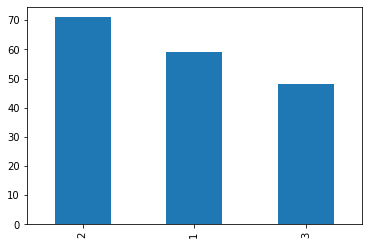

In [ ]:
clas=df_wine['Class label'].value_counts()
clas.plot(kind='bar')

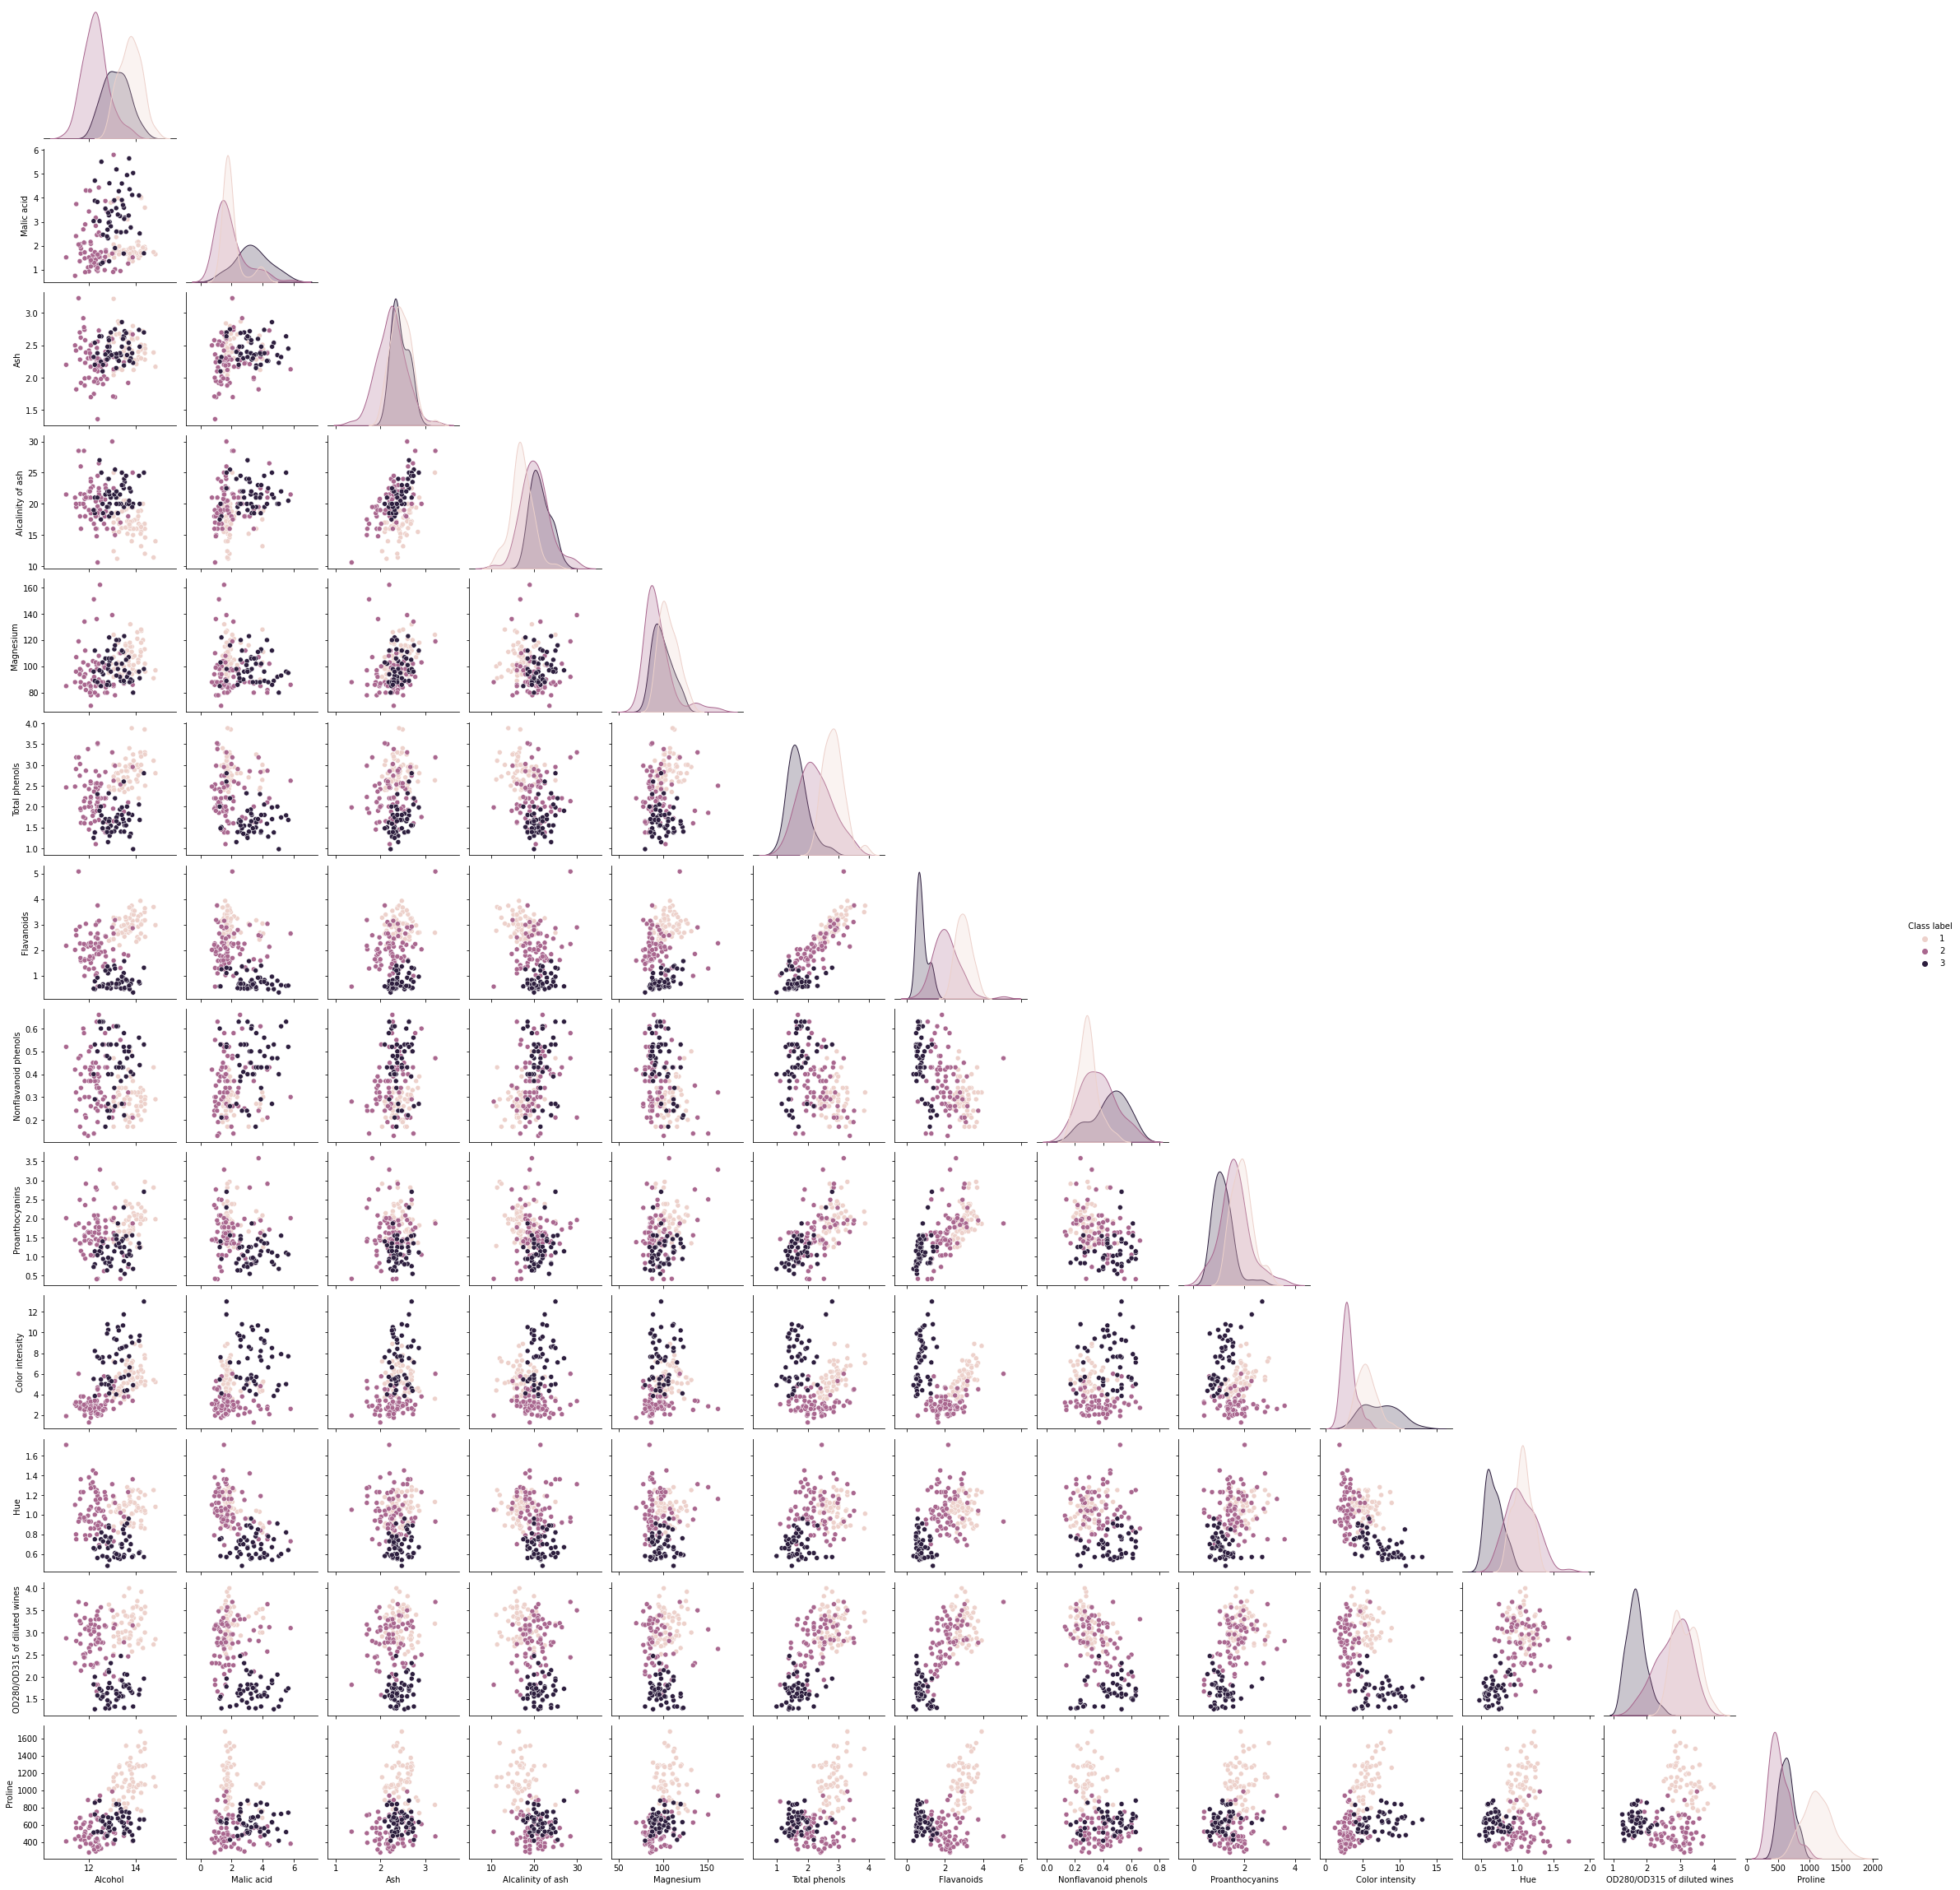

In [ ]:
sns.pairplot(df_wine, hue='Class label', corner=True)

<hr>

Splitting the data into 70% training and 30% test subsets.

In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

Standardizing the data.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_std

array([[ 0.71225893,  2.22048673, -0.13025864, ..., -0.20017028,
        -0.82164144, -0.62946362],
       [ 0.88229214, -0.70457155,  1.17533605, ...,  1.33982592,
         0.54931269,  1.47568796],
       [ 0.84585645, -0.73022996,  1.17533605, ...,  1.06806189,
         0.1308109 ,  1.62934866],
       ...,
       [ 1.02803489,  2.29746195, -0.5778911 , ..., -1.69487249,
        -1.86068037, -1.04434751],
       [-1.30384913, -1.08089484, -0.31677217, ...,  0.16218176,
         0.73691694,  0.40313628],
       [-0.40510216,  1.29678411,  0.05625489, ...,  1.06806189,
         0.73691694, -0.89683324]])

---

**Note**

Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 samples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify samples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these samples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify samples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- sample5: -18.37 -> class 2
- sample6: -17.15 -> class 2
- sample7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new samples" are much lower than every standardized feature in the training set.

---

<br>
<br>

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

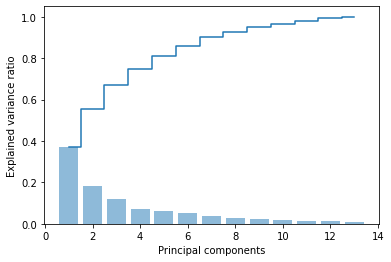

In [ ]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_train_pca

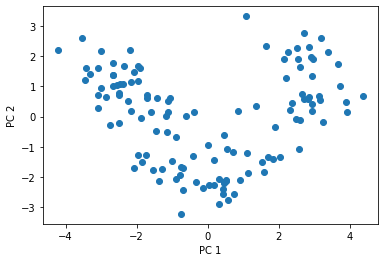

In [ ]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

Training logistic regression classifier using the first 2 principal components.

In [ ]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

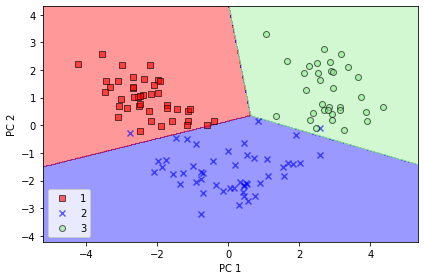

In [ ]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

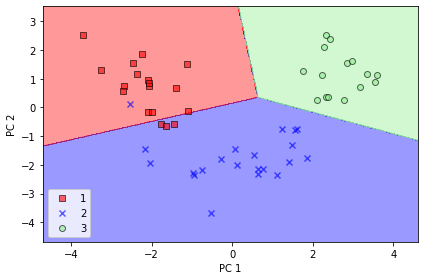

In [ ]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

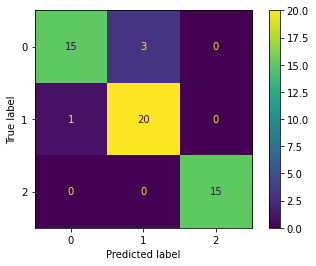

In [ ]:
# Confusion matrix

y_pred=lr.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

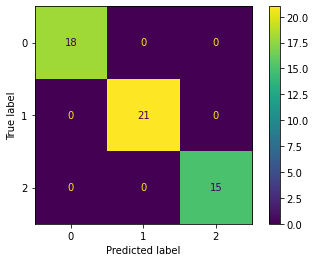

In [ ]:
# compare with non-pca data

lr_nopca = LogisticRegression()
lr_nopca=lr_nopca.fit(X_train_std, y_train)
y_pred_nopca=lr_nopca.predict(X_test_std)
cm_no = confusion_matrix(y_test, y_pred_nopca)
ConfusionMatrixDisplay(cm_no).plot()

In [ ]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
100*pca.explained_variance_ratio_     # Expresados en porcentaje

array([36.9514686 , 18.43492706, 11.81515909,  7.33425176,  6.42210782,
        5.05172448,  3.95465389,  2.64391832,  2.38931926,  1.62961377,
        1.38002112,  1.17222624,  0.82060857])

<br>
<br>

# Supervised data compression via linear discriminant analysis

## Principal component analysis versus linear discriminant analysis

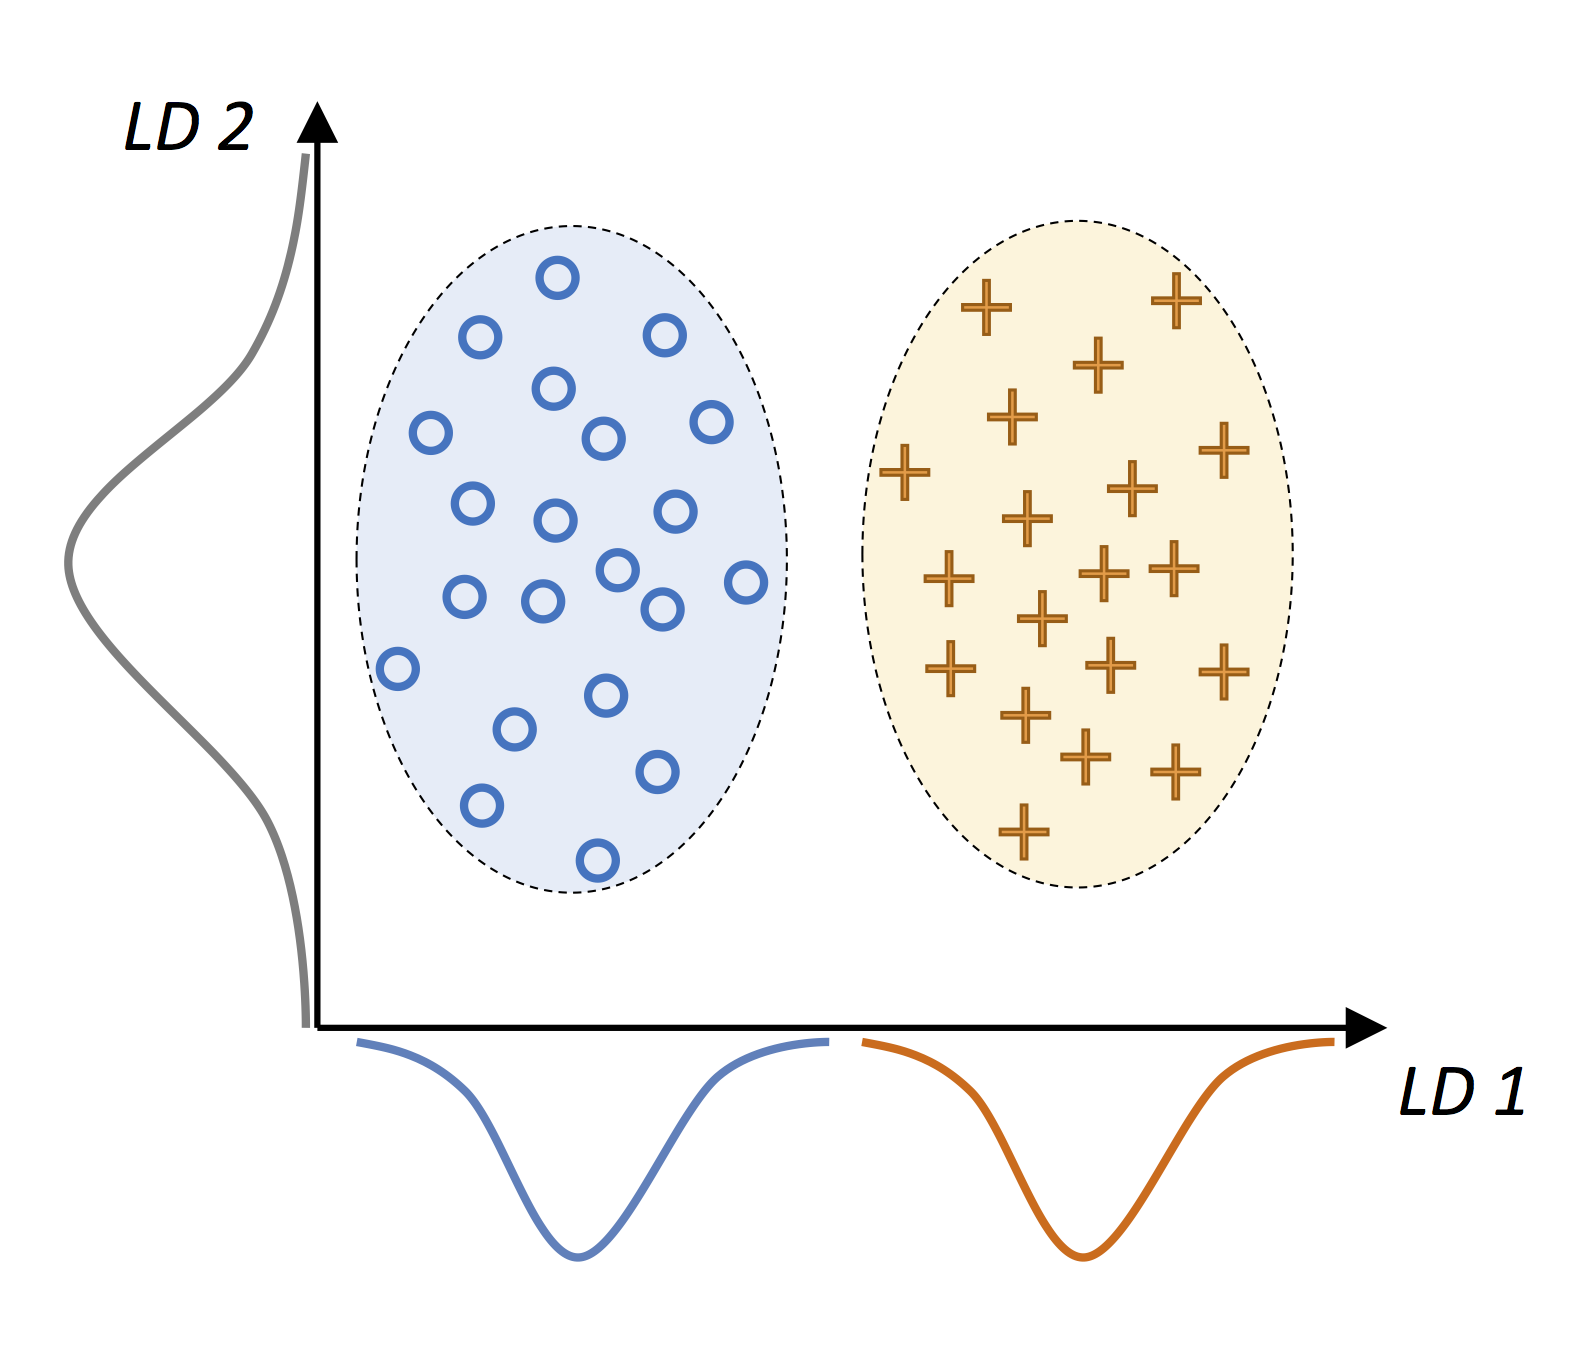

In [ ]:
Image(filename='images/05_06.png', width=400) 

<br>
<br>

## LDA via scikit-learn

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_train_lda

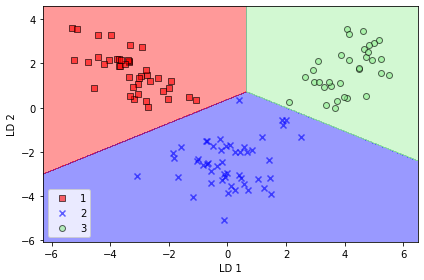

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_lda = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr_lda)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_09.png', dpi=300)
plt.show()

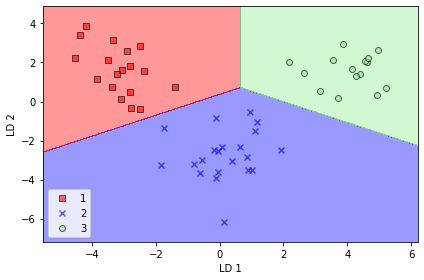

In [ ]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr_lda)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_10.png', dpi=300)
plt.show()

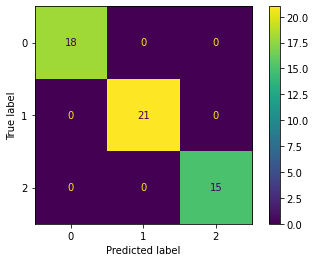

In [ ]:
# Confusion matrix

y_pred_lda=lr_lda.predict(X_test_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)
ConfusionMatrixDisplay(cm_lda).plot()

# BONUS 1

<br>
<br>

In [ ]:
df_wine2=df_wine.set_index('Class label')
df_wine2


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Class label,,,,,,,,,,,,,
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835


In [ ]:
# https://towardsdatascience.com/outlier-detection-using-principal-component-analysis-and-hotellings-t2-and-spe-dmodx-methods-625b3c90897
! pip install pca

# Import library
from pca import pca

In [ ]:
# Initialize pca to also detected outliers.
model_out = pca(normalize=True, detect_outliers=['ht2', 'spe'], n_std=2)   

# Fit and transform
results_out = model_out.fit_transform(df_wine2)


[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [13] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [10] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [13] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [ ]:
# Print outliers
print(type(results_out['outliers']))
print(results_out['outliers'])

<class 'pandas.core.frame.DataFrame'>
     y_proba     p_raw    y_score  y_bool  y_bool_spe  y_score_spe
1   0.982875  0.376726  21.351215   False       False     3.617239
1   0.982875  0.624371  17.438087   False       False     2.234477
1   0.982875  0.589438  17.969195   False       False     2.719789
1   0.982875  0.134454  27.028857   False        True     4.659735
1   0.982875  0.883264  12.861094   False       False     1.332104
..       ...       ...        ...     ...         ...          ...
3   0.982875  0.147396  26.583414   False        True     4.033903
3   0.982875  0.771408  15.087004   False       False     3.139750
3   0.982875  0.244157  23.959708   False        True     3.846217
3   0.982875  0.333600  22.128104   False       False     3.312952
3   0.982875  0.138437  26.888278   False        True     4.238283

[178 rows x 6 columns]


In [ ]:
print(results_out['outliers']['y_bool'])

1    False
1    False
1    False
1    False
1    False
     ...  
3    False
3    False
3    False
3    False
3    False
Name: y_bool, Length: 178, dtype: bool


[pca] >Plot PC1 vs PC2 with loadings.
[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Class label,,,,,,,,,,,,,


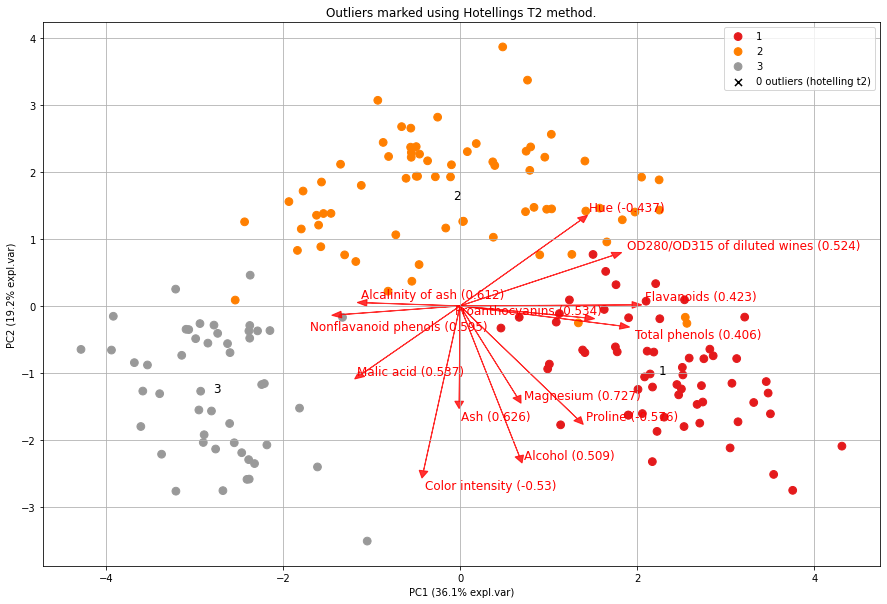

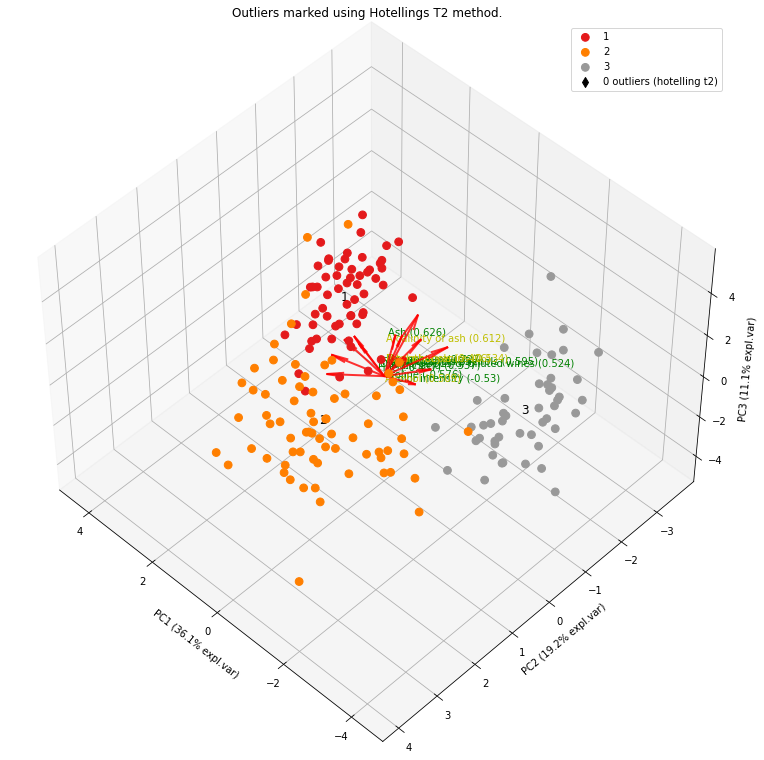

In [ ]:
# Plot Hotellings T2
model_out.biplot(SPE=False, hotellingt2=True, title='Outliers marked using Hotellings T2 method.')

# Make a plot in 3 dimensions
model_out.biplot3d(SPE=False, hotellingt2=True, title='Outliers marked using Hotellings T2 method.')

# Get the outliers using SPE/DmodX method.
df_wine2.loc[results_out['outliers']['y_bool'], :]

[pca] >Plot PC1 vs PC2 with loadings.
[pca] >Plot PC1 vs PC2 with loadings.


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Class label,,,,,,,,,,,,,
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,14.38,1.87,2.38,12.0,102,3.30,3.64,0.29,2.96,7.5,1.20,3.00,1547
1,14.19,1.59,2.48,16.5,108,3.30,3.93,0.32,1.86,8.7,1.23,2.82,1680
2,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.5,1.38,3.12,278
2,11.03,1.51,2.20,21.5,85,2.46,2.17,0.52,2.01,1.9,1.71,2.87,407
3,13.88,5.04,2.23,20.0,80,0.98,0.34,0.40,0.68,4.9,0.58,1.33,415
3,13.17,5.19,2.32,22.0,93,1.74,0.63,0.61,1.55,7.9,0.60,1.48,725
3,14.34,1.68,2.70,25.0,98,2.80,1.31,0.53,2.70,13.0,0.57,1.96,660
3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740


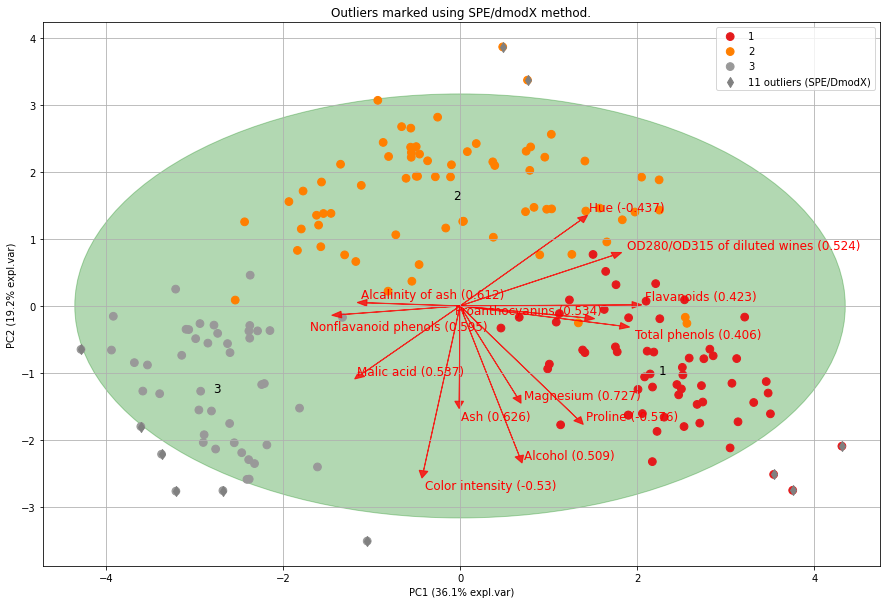

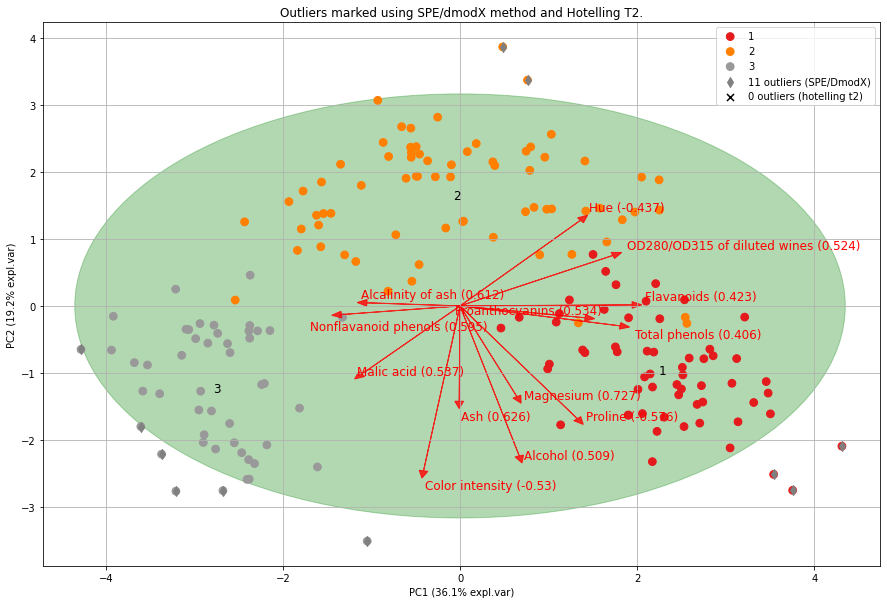

In [ ]:
# Plot SPE/DmodX method
model_out.biplot(SPE=True, hotellingt2=False, title='Outliers marked using SPE/dmodX method.')

# Make a plot in 3 dimensions
model_out.biplot(SPE=True, hotellingt2=True, title='Outliers marked using SPE/dmodX method and Hotelling T2.')

# Get the outliers using SPE/DmodX method.
df_wine2.loc[results_out['outliers']['y_bool_spe'], :]

In [ ]:
# Grab overlapping outliers
I_overlap = np.logical_and(results_out['outliers']['y_bool'], results_out['outliers']['y_bool_spe'])
print(I_overlap.isnull().sum())
# Print overlapping outliers
df_wine2.loc[I_overlap, :]

0


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Class label,,,,,,,,,,,,,


# BONUS 2


## Kernel principal component analysis in scikit-learn

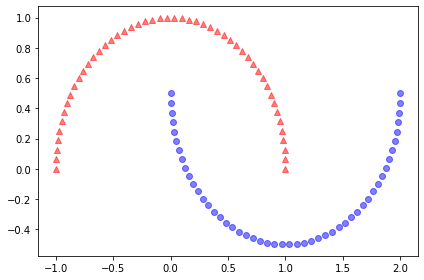

In [ ]:
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_12.png', dpi=300)
plt.show()


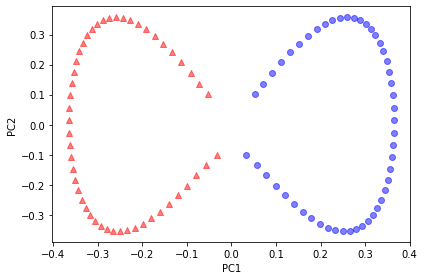

In [ ]:
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()